<center><h1>Segmentating and Clustering Neighborhoods in Toronto</h1></center>

### <center>Name: Nikesh Lama</center> 



### Introduction

In this notebook, we will explore, segment, and cluster the neighborhoods in the city of Toronto based on the postal code and borough information. However, unlike New York, the neighborhood data is not readily available on the internet. So first thing first, we need to scrape neighborhood data from toronto with via a wiki page <a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_Mhttps://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"> here</a>


To view the rendered maps copy the github link and open in <a href = "https://nbviewer.jupyter.org/"> Jupyter NBViewer </a>


First thing first, lets import necessary libraries and download all dependencies we need. I have put all library import here

In [1]:
import numpy as np #handl data in a vectorised manner
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import json
from pandas.io.json import json_normalize #json to panda df

#Visualisation
import matplotlib.cm as cm
import matplotlib.colors as colors

#k-means cluster
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes #already installed
import folium #map rendering library

#web scraping libs
from bs4 import BeautifulSoup
import requests

# Part 1 
### 1. Download, Explore and Prepare Dataset

Unfortunately, the data is not readily available to download. So, we need to do web scraping to collect the data for Toronto neighborhood.

For Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. What we aim to do now is:

* Scrape data from wiki page
* Wrangle the data
* Clean and read into panda dataframe


Scrape the web for the data

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" # wiki page with postal codes
html = requests.get(url).text

In [3]:
soup = BeautifulSoup(html, 'html5lib')

In [4]:
soup.title

<title>List of postal codes of Canada: M - Wikipedia</title>

In [5]:
#print(soup.prettify())

In [6]:
table = soup.find('table')
table_contents = []

<details><summary>My approach</summary>

```python
table_contents = []
for row in table.find_all('tr'):
    #print(row)
    data_cell = {}
    for col in row.find_all('td'):
        if col.span.text == 'Not assigned': # if the 
              pass
        else:
            data_cell['PostalCode'] = col.p.text[:3] 
            data_cell['Borough'] = (col.span.text).split('(')[0] # gives borough
            #(row.span.text).split('(')[0]
            data_cell['Neighborhood'] = ((((col.span.text).split('(')[1]).replace(' /',',')).replace(')',' ')).strip(' ')
            table_contents.append(data_cell)
   ```

</details>   

In [7]:
# iterate through each row and extract postcode, borough and neighborhood info
for row in table.findAll('td'):
    cell = {} #cell array for dic
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3] # the first three letters are postal code
        cell['Borough'] = (row.span.text).split('(')[0] # split string at parenthesis. the first half is the borough
        #essentially, we remove the parenthesis and replace '/' with a ','
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [8]:
df = pd.DataFrame(table_contents)
#cleaning data to remove unwanted info such as email link, po box etc... 
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [9]:
df.shape

(103, 3)

In [10]:
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


-------

# Part 2 
### 2. Get latitude and longitude of the neighborhood location and create a combined dataframe

Here, we will use python geocoder APO to get longitude and latitude data for each neighborhood location. We will then use these lat,long with foursquare API 

In [11]:
#!pip install geocoder

The geocoder api returned None. Hence, we will download the csv file directly

Code for getting latlong data using geocoder  -- <b>API KEYS NEEDED WHICH IS CHARGED SO AVOIDED!!</b>
```python
from IPython.display import clear_output
import geocoder # import geocoder

# initialize your variable to None
lat_lng_coords = None

# loop until you get the coordinates
while(lat_lng_coords is None):
    g = geocoder.google('Mountain View, CA')
    lat_lng_coords = g.latlng
    clear_output(wait=False)
    print(lat_lng_coords)

latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]
```

In [12]:
#!pip install pgeocode


> Tried pgeocode library as suggested by Laxmi in the discussion. I can get the lat long but the values are slightly off at 3 decimal place(CODE BELOW). SUGGESTED OPTION WAS TO USE THE .CSV FILE PROVIDED !!! SO I WILL BE USING THE CSV FILE DIRECTLY.
```python
import pgeocode
pgeocode.Nominatim('ca')
geolocator = pgeocode.Nominatim('ca')
postal_codes = df['PostalCode'].tolist()
latitudes = []
longitudes = []
for i, postal_code in enumerate(postal_codes):
    # initialize your variable to None
    #print(f'--Getting Postal Code: {postal_code}')
    g = geolocator.query_postal_code(postal_code)
    
    if not g.empty:
        #print(f'Postal Code {postal_code} has been retrieved. {len(postal_codes) - (i + 1)} codes left')
        latitudes.append(g.latitude)
        longitudes.append(g.longitude)
df['Latitudes'] = latitudes
df['Longitudes'] = longitudes
```

We will be using the provided csv file with latitude and longitude data. Lets download the data.

In [13]:
#!wget -O geospatial.csv "http://cocl.us/Geospatial_data"

In [14]:
geo_spa_df = pd.read_csv('geospatial.csv')

In [15]:
geo_spa_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge two tables to create a combined tables with borough, neighborhood and lat long data

In [16]:
# The col name is different so change it to match
geo_spa_df.rename(columns = {"Postal Code":"PostalCode"}, inplace = True)
new_df = df.merge(geo_spa_df, on = "PostalCode", how="inner")

In [17]:
new_df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


----------------------

# Part 3

### 3. Exploration of neighborhood clusters in Toronto

This is the last part of the assignment where we will use the data frame created up until now for cluster analysis. We will use foursquare api to explore the neighborhood and segment them, and use folium to visualisation

<b>FourSquare API credentials<b>
    
Credentials are read from a json file to avoid being pushed to the repo.

In [18]:
with open(r'Foursquare_cred.json') as f:
    data = json.load(f)
    fSquare_cred = {'CLIENT_ID':data['CLIENT_ID'], 'CLIENT_SECRET':data['CLIENT_SECRET']}

CLIENT_ID = data['CLIENT_ID']
CLIENT_SECRET = data['CLIENT_SECRET']

VERSION = '20180604'
LIMIT = 100
radius = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NQNDVRYUJJPXJPI4X13F5ZL3XRX4NRNHLTOEC1GATLBCLPG0
CLIENT_SECRET:5E10NP0GXAWXZPOOQHEJVSFQ4JE1KULDDYROQGHS2YFXDJCP


In [19]:
print('Toronto has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

Toronto has 15 boroughs and 103 neighborhoods.


<b> Create a map of Toronto with neighborhoods.<b>

In [20]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 43.6534817, -79.3839347.


<b> Create a folium map of Toronto with boroughs and neighborhood<b>

In [21]:
#create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location = [latitude, longitude], zoom_start = 10)

#add markers
for lat,lng, borough, neighborhood in zip(new_df['Latitude'],new_df['Longitude'],new_df['Borough'],new_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.6,
        parse_html = False).add_to(map_toronto)
map_toronto

### To make it simpler lets extract only the boroughs with Toronto in the name.

In [22]:
toronto_df = new_df.loc[new_df['Borough'].str.contains("Toronto")]
toronto_df.reset_index(drop = True, inplace=True)
toronto_df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259
9,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106


In [23]:
toronto_df.loc[1,'Neighborhood']

'Garden District, Ryerson'

### Explore all the neighborhodds in boroughs which has Toronto in the name

#### Helper function to extract category of the venue -- from foursquare lab

In [24]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Functino to iterate through each neighborhood and search upto desired distance for 100 most popular venues

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius = 500 ):
    venues_list = []
    for name, lat, long in zip(names, latitudes, longitudes):
        
        #set the url with foursquare credentials
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,radius,LIMIT)
        
        
        #Get data as json with a GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        #iterates through each item. 
        #if you wish to iterate via for loop, then use results[i]['venue'].... 
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    #reshape the list for dataframe and store into as a panda df
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood latitude',
                             'Neighbor longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    return (nearby_venues)


Now lets pass our toronto_df data for neighborhoods with toronto in the name to this function to return venues and co-ordinates

In [26]:
toronto_venues = getNearbyVenues(toronto_df['Neighborhood'],
                                 toronto_df['Latitude'],
                                 toronto_df['Longitude'],
                                radius = 500)

In [27]:
print("There are {} venues in the selected neighborhood in toronto. ".format(toronto_venues.shape[0]))

There are 1602 venues in the selected neighborhood in toronto. 


In [28]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 uniques categories.


### 10 most present venue categories

In [29]:
toronto_venues['Venue Category'].value_counts()[0:10]

Coffee Shop            141
Café                    87
Restaurant              54
Hotel                   39
Bakery                  39
Park                    37
Italian Restaurant      37
Japanese Restaurant     33
Gym                     27
Pizza Place             26
Name: Venue Category, dtype: int64

In [30]:
toronto_venues.groupby('Neighborhood').count().head(10)

,Neighborhood latitude,Neighbor longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",25,25,25,25,25,25
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,67,67,67,67,67,67
Christie,16,16,16,16,16,16
Church and Wellesley,78,78,78,78,78,78
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,35,35,35,35,35,35
Davisville North,9,9,9,9,9,9


### Lets analyse each neighborhood apply one hot encoding for venue category

In [31]:
#one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

#add neighborhood col back to the data frame
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']
#re arrange columns
first_column = toronto_onehot.pop('Neighborhood')
# insert column using insert(position,column_name,
# first_column) function
toronto_onehot.insert(0, 'Neighborhood', first_column)
toronto_onehot.head()
         

,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### Regroup rows by neighborhood and by taking the mean of the frequency of occurence of each category

In [32]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(10)

,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.0,0.0,0.0,0.017544,0.000000,0.0,0.00,0.0000,0.0,0.0,0.0000,0.017544,0.052632,0.000000,0.000000,0.0,0.017544,0.017544,0.0,0.035088,0.0,0.0,0.017544,0.0000,0.000000,0.0000,0.0,0.017544,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.017544,0.0,0.0,0.0000,0.000000,0.035088,0.0,0.0,0.0,0.00,0.017544,0.052632,0.070175,0.0,0.0,0.0,0.0,0.017544,0.000000,0.017544,0.00,0.0,0.0,0.017544,0.0,0.0,0.000000,0.00,0.017544,0.000000,0.017544,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.017544,0.0,0.000000,0.0,0.0,0.000000,0.035088,0.000000,0.0,0.0,

In [33]:
toronto_grouped.shape

(39, 237)

#### Lets evaluate top 5 most common venues  for each neighborhood

In [34]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("---------{}----------".format(hood))
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ["venue", "freq"]
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---------Berczy Park----------
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2              Bakery  0.05
3            Beer Bar  0.04
4  Seafood Restaurant  0.04


---------Brockton, Parkdale Village, Exhibition Place----------
                   venue  freq
0                   Café  0.12
1         Breakfast Spot  0.08
2                 Bakery  0.08
3  Performing Arts Venue  0.08
4            Coffee Shop  0.08


---------CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----------
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3           Airport  0.06
4             Plane  0.06


---------Central Bay Street----------
                venue  freq
0         Coffee Shop  0.18
1                Café  0.07
2      Sandwich Place  0.06
3  Italian Restaurant  0.04
4          Restaurant  0.03


---------Christie----------
           venue  freq
0  G

Now, lets put the rankings into the dataframe

In [35]:
#helper function to sort rankings
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Beer Bar,Seafood Restaurant,Cheese Shop,Farmers Market,Restaurant,Creperie,Fountain
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Bakery,Performing Arts Venue,Coffee Shop,Pet Store,Convenience Store,Restaurant,Climbing Gym,Nightclub
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Airport,Plane,Sculpture Garden,Coffee Shop,Rental Car Location,Boat or Ferry,Boutique
3,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Restaurant,Salad Place,Bubble Tea Shop,Japanese Restaurant,Burger Joint,Spa
4,Christie,Grocery Store,Café,Park,Baby Store,Nightclub,Candy Store,Italian Restaurant,Athletics & Sports,Restaurant,Coffee Shop


### Cluster Neighborhoods

We will use k-means to cluster neighborhood into 6 clusters

In [37]:
#no of clusters
k_clusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood',1)

#run k-means clustering

kmeans = KMeans(n_clusters=k_clusters, random_state = 0).fit(toronto_grouped_clustering)

#check clusters labels 
kmeans.labels_[0:10]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

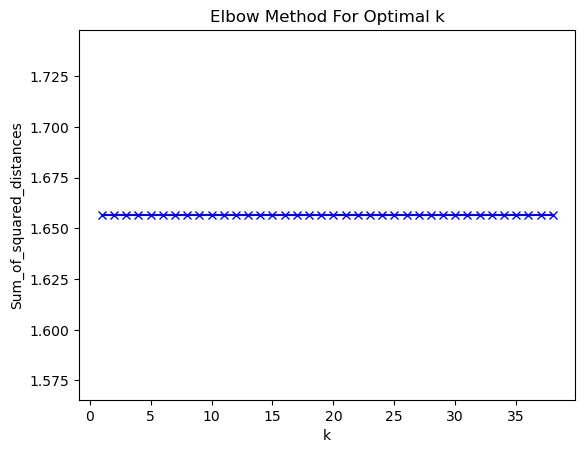

In [40]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood',1)
import matplotlib.pyplot as plt
elbow = []
#run k-means clustering
for k in range(1,len(toronto_grouped_clustering)):
    kmeans = KMeans(n_clusters=k_clusters, random_state = 0).fit(toronto_grouped_clustering)
    elbow.append(kmeans.inertia_)

K = range(1,len(toronto_grouped_clustering))
plt.plot(K,  elbow,'bx-')
plt.xlabel('k')  
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Store clusters labels to the data frame

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Spa,Mexican Restaurant
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Hotel,Cosmetics Shop,Japanese Restaurant,Café,Bubble Tea Shop,Ramen Restaurant,Lingerie Store,Electronics Store
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Restaurant,Clothing Store,Cocktail Bar,Cosmetics Shop,Bakery,Theater,Gym,Moroccan Restaurant
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Health Food Store,Trail,Pub,Movie Theater,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Beer Bar,Seafood Restaurant,Cheese Shop,Pub,Farmers Market,Restaurant


#### Visualise Clusters

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Lets look at each cluster 

#### Cluster 0

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Downtown Toronto,0,Grocery Store,Café,Park,Candy Store,Italian Restaurant,Baby Store,Nightclub,Restaurant,Coffee Shop,Moroccan Restaurant
29,Central Toronto,0,Park,Restaurant,Tennis Court,Airport,Movie Theater,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant


#### Cluster 2

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Spa,Mexican Restaurant
1,Downtown Toronto,1,Coffee Shop,Clothing Store,Hotel,Cosmetics Shop,Japanese Restaurant,Café,Bubble Tea Shop,Ramen Restaurant,Lingerie Store,Electronics Store
2,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Clothing Store,Cocktail Bar,Cosmetics Shop,Bakery,Theater,Gym,Moroccan Restaurant
3,East Toronto,1,Health Food Store,Trail,Pub,Movie Theater,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant
4,Downtown Toronto,1,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Beer Bar,Seafood Restaurant,Cheese Shop,Pub,Farmers Market,Restaurant
5,Downtown Toronto,1,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Restaurant,Salad Place,Spa,Japanese Restaurant,Burger Joint,Bubble Tea Shop
7,Downtown Toronto,1,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Thai Restaurant,Bar,Gym,Breakfast Spot,Bookstore
8,West Toronto,1,Pharmacy,Bakery,Bank,Middle Eastern Restaurant,Bar,Supermarket,Furniture / Home Store,Music Venue,Café,Grocery Store
10,Downtown Toronto,1,Coffee Shop,Aquarium,Café,Hotel,Fried Chicken Joint,Restaurant,Scenic Lookout,Brewery,History Museum,Baseball Stadium
11,West Toronto,1,Bar,Asian Restaurant,Vietnamese Restaurant,Restaurant,Diner,Men's Store,Café,Yoga Studio,Bistro,Brewery


#### Cluster 3

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,2,Park,Bus Line,Swim School,Airport,Moroccan Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant
21,Central Toronto,2,Park,Trail,Jewelry Store,Sushi Restaurant,Airport,Moroccan Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Men's Store
33,Downtown Toronto,2,Park,Playground,Trail,Airport,Movie Theater,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant


#### Cluster 4

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,3,Garden,Airport,Movie Theater,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop


#### Cluster 5

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,East York/East Toronto,4,Convenience Store,Park,Coffee Shop,Museum,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
